# Temporal Linear Network (TLN) for VWAP prediction

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import keras
from tln import TLN

# Suppress TensorFlow warnings for cleaner output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Step 1: Data loading and initial prep

In [49]:
# Load the dataset
df = pd.read_csv('../datasets/META_1min_firstratedata.csv')

# Convert timestamp and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['avg_price'] = (df['high'] + df['low']) / 2
df.set_index('timestamp', inplace=True)

# Filter for standard trading hours (9:30 AM - 4:00 PM)
trading_hours_df = df.between_time('09:30', '16:00').copy()

### Step 2: split data into training and testing sets

In [50]:
# Get unique dates
dates = df.index.normalize().unique()

# Split dates
train_dates = dates[:int(len(dates) * 0.75)]

# Create masks
mask = df.index.normalize().isin(train_dates)
train_df = df[mask].copy()
test_df = df[~mask].copy()

### Step 3: prepare data for TLN model

In [51]:
def create_tln_sequences(df, lookback_window, horizon):
    """
    Creates sequences of data for training the TLN model.
    X: Input features (lookback_window minutes of price and volume).
    y: Target data (horizon minutes of price and market volume for loss calculation).
    """

    features = ['avg_price', 'volume']
    X, y = [], []

    # Group by day to create sequences within each trading day
    daily_groups = df.groupby(df.index.date)
    
    for date, group in daily_groups:
        feature_data = group[features].values
        price_volume_data = group[['avg_price', 'volume']].values
        
        if len(feature_data) < lookback_window + horizon:
            continue
            
        for i in range(len(feature_data) - lookback_window - horizon + 1):
            X.append(feature_data[i : i + lookback_window])
            y.append(price_volume_data[i + lookback_window : i + lookback_window + horizon])
            
    return np.array(X), np.array(y)

### Define model parameters

In [52]:
LOOKBACK = 120  # Use the past 120 minutes of data
HORIZON = 30    # To predict the execution schedule for the next 30 minutes
FEATURES = ['avg_price', 'volume']
NUM_FEATURES = len(FEATURES)

In [53]:
def calculate_market_impact(volatility, shares_to_trade, avg_daily_volume):
    """
    Calculates market impact using the square-root model.
    - volatility: Std dev of prices for the day.
    - shares_to_trade: Shares for this minute.
    - avg_daily_volume: Mean volume for the day.
    Returns impact cost (added to price for buys).
    """
    if avg_daily_volume <= 0 or shares_to_trade <= 0:
        return 0.0  # No impact for invalid cases
    participation_rate = shares_to_trade / avg_daily_volume
    impact = volatility * np.sqrt(participation_rate)
    return impact if not np.isnan(impact) else 0.0

In [54]:
# Create training and testing sequences
print("\nCreating TLN sequences...")
X_train, y_train = create_tln_sequences(train_df, LOOKBACK, HORIZON)
X_test, y_test = create_tln_sequences(test_df, LOOKBACK, HORIZON)

print(f"Training data shape: X_train -> {X_train.shape}, y_train -> {y_train.shape}")
print(f"Testing data shape: X_test -> {X_test.shape}, y_test -> {y_test.shape}")


Creating TLN sequences...
Training data shape: X_train -> (94911, 120, 2), y_train -> (94911, 30, 2)
Testing data shape: X_test -> (29969, 120, 2), y_test -> (29969, 30, 2)


### Step 4: define custom vwap loss function and TLN model


In [55]:
def vwap_loss(y_true, y_pred):
    """
    Custom Keras loss function to minimize the quadratic VWAP slippage.
    The model predicts the allocation schedule (y_pred).
    y_true contains the actual market prices and volumes needed to calculate the benchmark.
    """
    
    # Extract future prices and market volumes from y_true
    future_prices = y_true[:, :, 0]
    market_volumes = y_true[:, :, 1]

    # Calculate the VWAP achieved by the model's predicted schedule
    model_trade_value = keras.ops.sum(y_pred * future_prices, axis=1)
    model_total_shares = keras.ops.sum(y_pred, axis=1)
    model_vwap = model_trade_value / (model_total_shares + 1e-8) # Add epsilon for stability

    # Calculate the benchmark VWAP using market volumes
    benchmark_trade_value = keras.ops.sum(market_volumes * future_prices, axis=1)
    benchmark_total_volume = keras.ops.sum(market_volumes, axis=1)
    benchmark_vwap = benchmark_trade_value / (benchmark_total_volume + 1e-8)

    # The loss is the squared difference between the two VWAPs (slippage)
    slippage = model_vwap - benchmark_vwap
    return keras.ops.square(slippage)
   

In [56]:
# Define the TLN model architecture
# The model's output is an allocation schedule, ensured by the softmax activation[7]
tln_model = keras.Sequential([
    keras.Input(shape=(LOOKBACK, NUM_FEATURES)),
    TLN(
        output_len=HORIZON,
        output_features=1, # The model will internally produce one value per timestamp
        hidden_layers=2,
        use_convolution=True
    ),
    keras.layers.Flatten(),
    # The final Dense layer ensures the output matches the horizon length
    keras.layers.Dense(HORIZON, activation='softmax') 
])


In [57]:
# Compile the model with our custom loss function
tln_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=vwap_loss)
tln_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tln_3 (TLN)                     │ (None, 30, 1)          │         5,414 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 30)             │           930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,344 (24.78 KB)

 Trainable params: 6,344 (24.78 KB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Train the TLN Model

In [58]:
print("\nTraining the TLN model...")
history = tln_model.fit(
    X_train,
    y_train,
    epochs=20,  # A smaller number of epochs is often sufficient with a direct loss function
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Training the TLN model...
Epoch 1/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1617 - val_loss: 0.1232
Epoch 2/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1428 - val_loss: 0.1208
Epoch 3/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1415 - val_loss: 0.0248
Epoch 4/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0222 - val_loss: 0.0234
Epoch 5/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0190 - val_loss: 0.0226
Epoch 6/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0193 - val_loss: 0.0221
Epoch 7/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0182 - val_loss: 0.0223
Epoch 8/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0172 - val_loss: 0.0228
Epoch 9/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0195 - val_loss: 0.0237
Epoch 10/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0193 - val_loss: 0.0223
Epoch 11/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0177 - val_loss: 0.0225
Epo

### Step 6: backtesting and evaluation with trained TLN model

In [59]:
def calculate_benchmark_vwap(daily_df):
    """Calculates the true market VWAP for a given day."""
    if daily_df.empty or daily_df['volume'].sum() == 0:
        return np.nan
    return (daily_df['avg_price'] * daily_df['volume']).sum() / daily_df['volume'].sum()

In [ ]:
def evaluate_tln_strategy(test_df, model, total_shares_to_trade=1_000_000):
    """
    Backtests the trained TLN model on the test data.
    """
    daily_groups = test_df.groupby(test_df.index.date)
    results = []

    for date, day_data in daily_groups:
        if len(day_data) < LOOKBACK + HORIZON:
            continue

        benchmark_vwap = calculate_benchmark_vwap(day_data)
        if pd.isna(benchmark_vwap):
            continue

        # Simulate trading for the day
        total_value_of_trades = 0
        total_shares_traded = 0
        
        # We trade from the first possible moment until the end of the day
        for i in range(len(day_data) - LOOKBACK):
            # Prepare the input sequence for the model
            input_sequence = day_data[i : i + LOOKBACK][FEATURES].values
            input_sequence = np.expand_dims(input_sequence, axis=0) # Add batch dimension

            # Predict the allocation schedule for the next HORIZON minutes
            predicted_schedule = model.predict(input_sequence, verbose=0)[0]
            
            # Determine shares to trade in the next minute based on the schedule
            # We only execute the first step of the horizon prediction
            shares_to_trade_next_minute = predicted_schedule[0] * total_shares_to_trade
            
            # Get the price for the trade
            base_price = day_data.iloc[i + LOOKBACK]['avg_price']

            historical_data = day_data.iloc[:i + LOOKBACK + 1]
            daily_volatility = historical_data['avg_price'].std() if len(historical_data) > 1 else 0.0
            avg_daily_volume = historical_data['volume'].mean() if len(historical_data) > 0 else 1.0

            # Apply market impact (for buy orders only)
            impact = calculate_market_impact(daily_volatility, shares_to_trade_next_minute, avg_daily_volume)
            execution_price = base_price + impact  # Adjust price upward for impact

            # Accumulate trade value and shares
            total_value_of_trades += shares_to_trade_next_minute * execution_price
            total_shares_traded += shares_to_trade_next_minute

        if total_shares_traded == 0:
            continue

        model_vwap = total_value_of_trades / total_shares_traded
        
        # Calculate slippage
        slippage = model_vwap - benchmark_vwap
        slippage_bps = (slippage / benchmark_vwap) * 10000 if benchmark_vwap != 0 else np.nan

        results.append({
            'date': date,
            'benchmark_vwap': benchmark_vwap,
            'model_vwap': model_vwap,
            'slippage': slippage,
            'slippage_bps': slippage_bps
        })
        
    return pd.DataFrame(results)

### Step 7: run evaluation and display results


Evaluating TLN model performance on the test set...

--- TLN Model Performance Summary ---
Average Slippage: 81.76 bps
Standard Deviation of Slippage: 47.27 bps
Number of Days Tested: 63

--- First 5 Days of Results ---
         date  benchmark_vwap  model_vwap  slippage  slippage_bps
0  2023-07-03      286.620064  287.209526  0.589462     20.565956
1  2023-07-05      294.702689  298.491906  3.789217    128.577625
2  2023-07-06      294.375084  296.318672  1.943588     66.024200
3  2023-07-07      292.016067  293.444449  1.428382     48.914503
4  2023-07-10      292.544818  293.905970  1.361152     46.527983


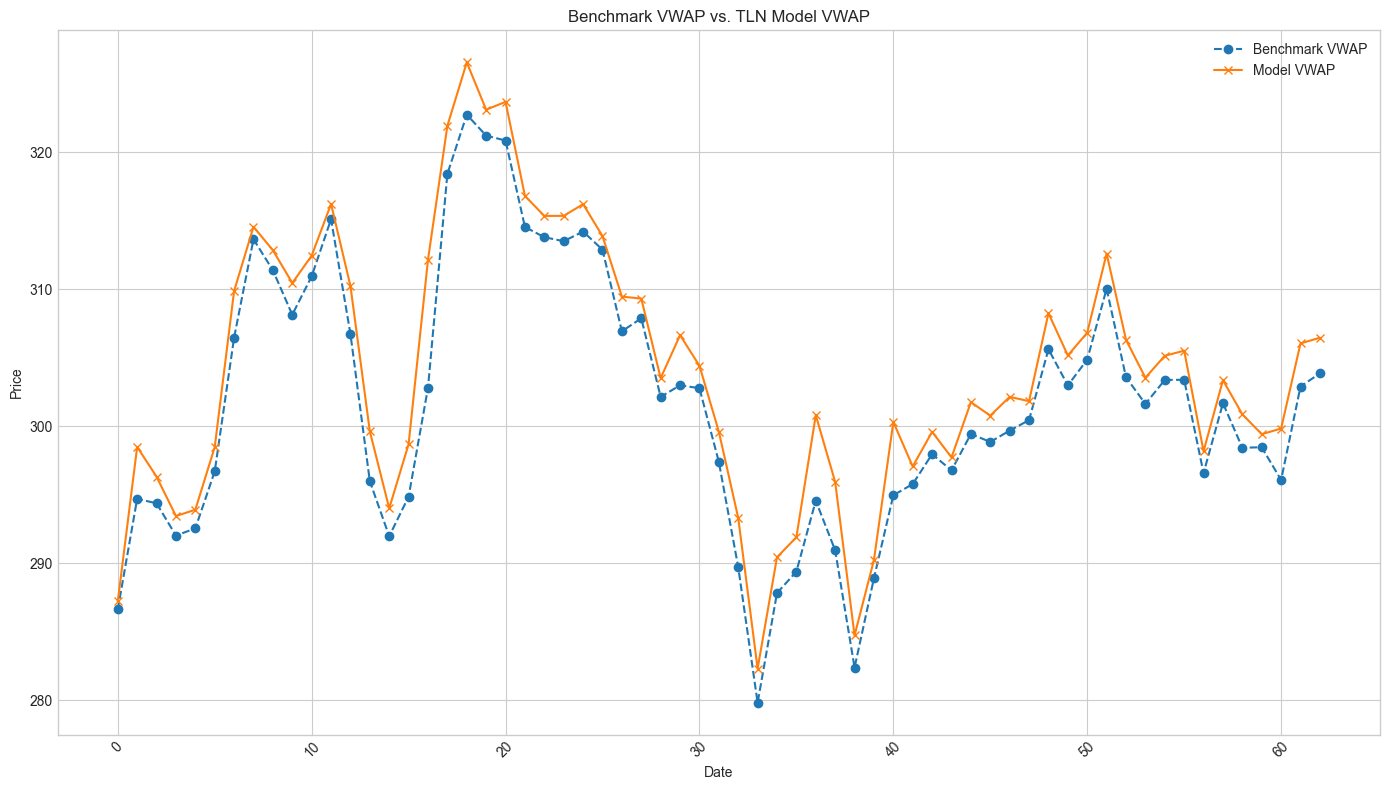

In [65]:
print("\nEvaluating TLN model performance on the test set...")
results_df = evaluate_tln_strategy(test_df, tln_model)

# Perform calculations
avg_slippage_bps = results_df['slippage_bps'].mean()
std_slippage_bps = results_df['slippage_bps'].std()

# Print summary
print(f"\n--- TLN Model Performance Summary ---")
print(f"Average Slippage: {avg_slippage_bps:.2f} bps")
print(f"Standard Deviation of Slippage: {std_slippage_bps:.2f} bps")
print(f"Number of Days Tested: {len(results_df)}")
print("\n--- First 5 Days of Results ---")
print(results_df.head())

# Plot the results
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))
plt.plot(results_df.index, results_df['benchmark_vwap'], label='Benchmark VWAP', marker='o', linestyle='--')
plt.plot(results_df.index, results_df['model_vwap'], label='Model VWAP', marker='x', linestyle='-')
plt.title('Benchmark VWAP vs. TLN Model VWAP')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

